## Лабораторна робота No3/4
## Виконав: ІП-13 Ал Хадам Мурат Резгович
## Перевірив: Баришич Лука Маріянович

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/car_evaluation.csv', header=None)
df.columns =['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df

,buying,meant,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   meant     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
df.describe()

,buying,meant,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


Train/test split

In [6]:
X = df.drop(["class"], axis=1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [7]:
X_train.shape, X_test.shape

((1382, 6), (346, 6))

In [8]:
y_train.shape, y_test.shape

((1382,), (346,))

Encoding

In [9]:
X_encoder = ce.OrdinalEncoder(cols=['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety'])
X_train = X_encoder.fit_transform(X_train)
X_test = X_encoder.transform(X_test)
print(X_train)
print(X_test)

      buying  meant  doors  persons  lug_boot  safety
107        1      1      1        1         1       1
901        2      1      2        2         2       2
1709       3      2      1        3         1       1
706        4      3      3        3         3       2
678        4      3      2        3         3       3
...      ...    ...    ...      ...       ...     ...
1130       2      3      2        1         3       1
1294       2      2      1        1         1       2
860        4      2      1        1         3       1
1459       3      4      3        3         2       2
1126       2      3      2        1         2       2

[1382 rows x 6 columns]
      buying  meant  doors  persons  lug_boot  safety
599        4      4      3        3         3       1
1201       2      2      4        2         3       2
628        4      4      1        3         1       2
1498       3      4      1        2         3       2
1263       2      2      3        1         3       3
...

In [10]:
y_encoder = ce.OrdinalEncoder(cols=['class'])
y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [11]:
y_train["class"] = list(map(lambda x: x - 1, y_train["class"]))
y_test["class"] = list(map(lambda x: x - 1, y_test["class"]))

In [12]:
y_encoder

OrdinalEncoder(cols=['class'],
               mapping=[{'col': 'class', 'data_type': dtype('O'),
                         'mapping': unacc    1
acc      2
vgood    3
good     4
NaN     -2
dtype: int64}])

In [13]:
def conf_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_labels = ['Class {}'.format(i) for i in range(len(cm))]
    cm_matrix = pd.DataFrame(data=cm, index=cm_labels, columns=cm_labels)

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def generate_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred)
    print(report)


def plot_roc_curve(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    overall_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    print(f'Overall AUC: {overall_auc:.2f}')

    plt.figure()

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class{i}) area = {round(roc_auc[i], 5)}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')

    plt.show()


grid_param = {
    'n_estimators': [200, 350, 500, 1000, 2000, 4000],
    'max_depth': [10, 20, 30]
}

Random Forest

In [14]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=grid_param, cv=5, scoring='accuracy')

In [15]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [200, 350, 500, 1000, 2000, 4000]},
             scoring='accuracy')

In [16]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 30, 'n_estimators': 350}
Best Score: 0.960916653586564


In [17]:
best_rf_classifier = grid_search.best_estimator_

In [18]:
y_predicted = best_rf_classifier.predict(X_test)
y_score = best_rf_classifier.predict_proba(X_test)

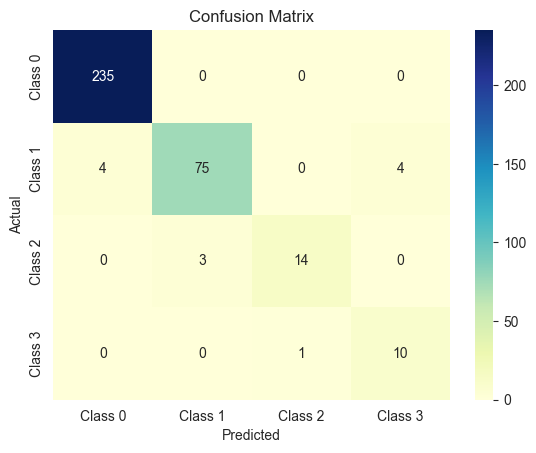

In [19]:
conf_matrix(y_test, y_predicted)

Overall AUC: 1.00


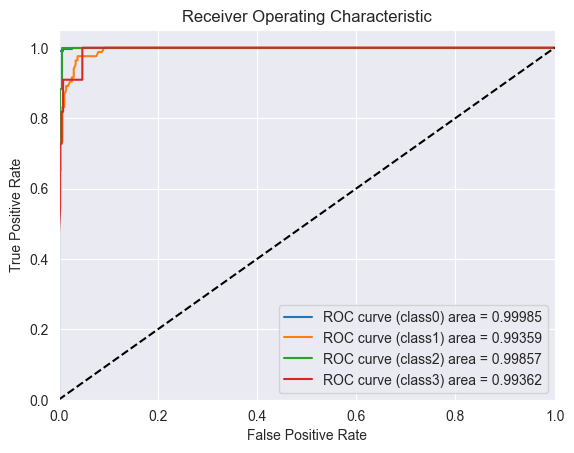

In [20]:
plot_roc_curve(y_test, y_score)

In [21]:
generate_classification_report(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       235
           1       0.96      0.90      0.93        83
           2       0.93      0.82      0.87        17
           3       0.71      0.91      0.80        11

    accuracy                           0.97       346
   macro avg       0.90      0.91      0.90       346
weighted avg       0.97      0.97      0.97       346



XGBoost

In [22]:
xgboost_rf = XGBRFClassifier()
grid_search_xgboost_rf = GridSearchCV(estimator=xgboost_rf, param_grid=grid_param, cv=5, scoring='accuracy')

In [23]:
grid_search_xgboost_rf.fit(X_train, y_train)
print("Best Parameters:", grid_search_xgboost_rf.best_params_)
print("Best Score:", grid_search_xgboost_rf.best_score_)

Best Parameters: {'max_depth': 20, 'n_estimators': 350}
Best Score: 0.9609192696070737


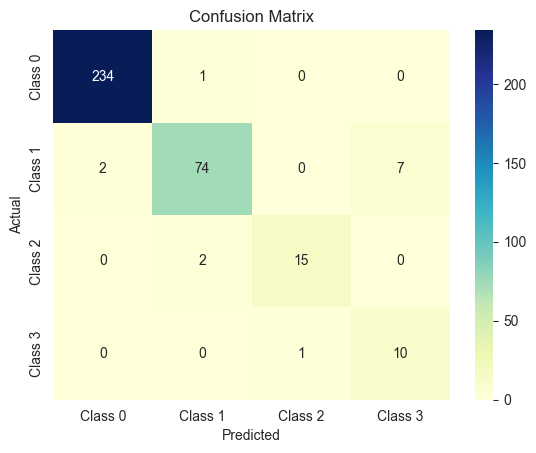

In [25]:
conf_matrix(y_test, y_predicted)

Overall AUC: 1.00


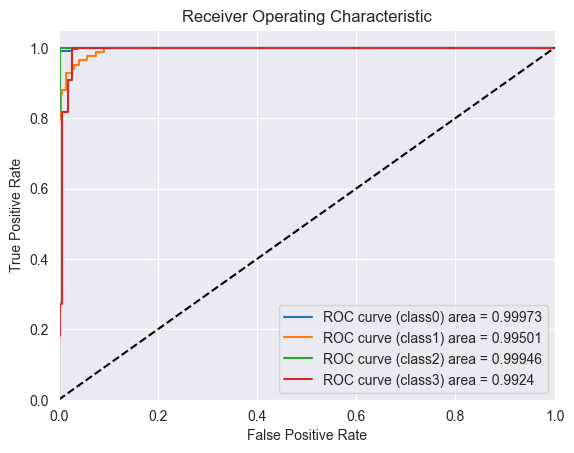

In [26]:
plot_roc_curve(y_test, y_score)

In [27]:
generate_classification_report(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.96      0.89      0.92        83
           2       0.94      0.88      0.91        17
           3       0.59      0.91      0.71        11

    accuracy                           0.96       346
   macro avg       0.87      0.92      0.89       346
weighted avg       0.97      0.96      0.96       346



Висновки цієї лабораторної роботи підкреслюють важливість проведення комплексного аналізу набору даних для оцінки
автомобілів з використанням двох моделей класифікації: класифікатора випадкових лісів та класифікатора випадкових лісів
XGBoost. Набір даних було досліджено, попередньо оброблено та розділено на навчальну та тестову вибірки. Згодом обидві
моделі були навчені та оптимізовані за допомогою GridSearchCV для визначення найбільш ефективних гіперпараметрів.
Результати показали, що як класифікатор випадкових лісів, так і XGBoost Random Forest Classifier продемонстрували високу
продуктивність, про що свідчать різні метрики оцінки, включаючи точність, матриці помилок, ROC-криві та звіти про
класифікацію. Ці результати підкреслюють вирішальну роль попередньої обробки даних, точного налаштування моделей і
ретельної оцінки в області застосування машинного навчання.